In [1]:
import pandas as pd
import os
import glob
import ipaddress
import itertools
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from scipy.signal import peak_prominences

In [2]:
fp = '/teams/DSC180A_FA20_A00/b05vpnxray/group2_data/data'
PACKET_TIMESTAMP_UNIT = 'ms'

In [3]:
filelist = os.listdir(fp)
netflix_files = [f for f in filelist if 'netflix' in f]
prime_files = [f for f in filelist if 'prime' in f]
youtube_files = [f for f in filelist if 'youtube' in f]

n1 = pd.read_csv(os.path.join(fp, netflix_files[1]))
p1 = pd.read_csv(os.path.join(fp, prime_files[0]))
y1 = pd.read_csv(os.path.join(fp, youtube_files[0]))

In [4]:
[f for f in filelist if 'csv' not in f]

['.ipynb_checkpoints']

In [5]:
[f for f in filelist if 'live' in f][0].split('live')

['tiq004-twitch-', '-011121-22.csv']

In [6]:
def loop_through_files():
    for filename in filelist:
        streaming_providers = {
            'youtube' : 0,
            'amazonprime': 1,
            'netflix': 2,
            'youtube-live': 3,
            'twitch-live': 4
        }

        if 'live' in filename:
            if 'twitch' in filename:
                provider_int = streaming_providers['twitch-live']
            if 'youtube' in filename:
                provider_int = streaming_providers['youtube-live']
        if 'live' not in filename:
            provider_int = -1
            if 'youtube' in filename:
                provider_int = streaming_providers['youtube']
            if 'amazonprime' in filename:
                provider_int = streaming_providers['amazonprime']
            if 'netflix' in filename:
                provider_int = streaming_providers['netflix']
                
        print(filename + ': ' + str(provider_int))
loop_through_files()

jeq004_netflix_1080p_1x_vpn_mac_clean_20210106b-8.csv: 2
jeq004_netflix_1080p_1x_vpn_mac_clean_20210107-16.csv: 2
tiq004-twitch-live-011121-22.csv: 4
jeq004_netflix_1080p_1x_vpn_mac_clean_20210105-9.csv: 2
jeq004_discovery_1080p_1x_vpn_mac_clean_20210125-8.csv: -1
maqader-twitch-live-1112021-5.csv: 4
chang_amazonprime_3.csv: 1
jeq004_netflix_1080p_1x_vpn_mac_clean_20210104-27.csv: 2
zishun-youtube-live-14.csv: 3
chang_amazonprime_4.csv: 1
jeq004_netflix_1080p_1x_vpn_mac_clean_20210104-20.csv: 2
zishun-youtube-live-13.csv: 3
jeq004_netflix_1080p_1x_vpn_mac_clean_20210106b-20.csv: 2
tiq004-twitch-live-011121-25.csv: 4
jeq004_netflix_1080p_1x_vpn_mac_clean_20210107-11.csv: 2
maqader-twitch-live-1112021-2.csv: 4
chang_amazonprime_24.csv: 1
arv020_hulu_1080p_1x_vpn_mac_clean_15.csv: -1
jeq004_netflix_1080p_1x_vpn_mac_clean_20210106b-1.csv: 2
jeq004_youtube_1080p_1x_vpn_mac_clean_20210109-2.csv: 0
jeq004_netflix_1080p_1x_vpn_mac_clean_20210105-0.csv: 2
jeq004_discovery_1080p_1x_vpn_mac_clean

In [7]:
def clean(df):
    """
    Attempts to filter out everything besides the traffic flow between the
    client and VPN service.

    The primary part of cleaning is merely getting rid of irrelevant flows.
    Since we are operating under the assumption that a VPN is in use, our
    clearning can *hopefully* isolate just the client<->VPN flow.

    At the moment, our approach is to remove any communications to link-local
    IPs, any multicast communications, and any communications between two
    private IPs.
    """

    ip1, ip2 = df.IP1.map(ipaddress.ip_address), df.IP2.map(ipaddress.ip_address)

    either_link_local = (
        (ip1.map(lambda x: x.is_link_local))
        | (ip2.map(lambda x: x.is_link_local))
    )

    either_multicast = (
        (ip1.map(lambda x: x.is_multicast))
        | (ip2.map(lambda x: x.is_multicast))
    )

    both_private = (
        (ip1.map(lambda x: x.is_private))
        & (ip2.map(lambda x: x.is_private))
    )

    return df[
        ~either_link_local
        & ~either_multicast
        & ~both_private
    ]

def unbin(df):
    """
    Takes in a DataFrame formatted as a network-stats output and 'unbins' the
    packet-level measurements so that each packet gets its own row.
    """
    
    packet_cols = ['packet_times', 'packet_sizes', 'packet_dirs']
    
    # Convert the strings `val1;val2;` into lists `[val1, val2]`
    df_listed = (
        df[packet_cols]
        .apply(lambda ser: ser.str.split(';').str[:-1])
    )
    
    # 'Explode' the lists so each element gets its own row.
    #
    # Exploding is considerably faster than summing lists and creating a new
    # frame.
    unbinned = (
        df_listed
        # Each list contains integer values, so we'll also cast them now.
        .apply(lambda ser: ser.explode(ignore_index=True).astype(int))
    )
    
    return unbinned

In [8]:
def process_file(df):
    """
    Filters out irrelevant traffic, then extracts packet-level data.
    """
    
    # print(f'Processing {filepath}')

    #df = pd.read_csv(filepath)
    
    # Filter out irrelevant traffic
    df = clean(df)

    # Extract packet-level data
    df = unbin(df)
    
    # Set the index to timedelta (should be monotonic increasing)
    df.columns = ['time', 'size', 'dir'] # NOTE: Renaming to match existing code
    df = df.sort_values('time')
    df['dt_time'] = pd.to_timedelta(df.time - df.time[0], PACKET_TIMESTAMP_UNIT)
    df = df.set_index('dt_time')

    # Finally, save the preprocessed file.
    #df.to_csv(pathlib.Path(out_dir, 'preprocessed-'+filepath.name))

    return df

In [9]:
n1_unpacked = process_file(n1)
p1_unpacked = process_file(p1)
y1_unpacked = process_file(y1)

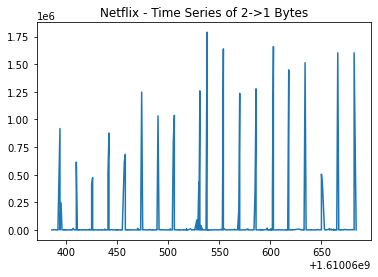

In [10]:
plt.plot(n1['Time'], n1['2->1Bytes'])
plt.title('Netflix - Time Series of 2->1 Bytes');

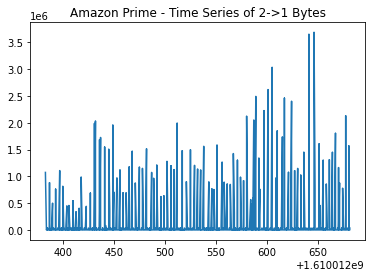

In [11]:
plt.plot(p1['Time'], p1['2->1Bytes'])
plt.title('Amazon Prime - Time Series of 2->1 Bytes');

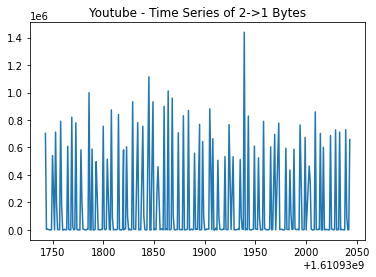

In [12]:
plt.plot(y1['Time'], y1['2->1Bytes'])
plt.title('Youtube - Time Series of 2->1 Bytes');

Netflix maximum prominence:  503135.1866261307


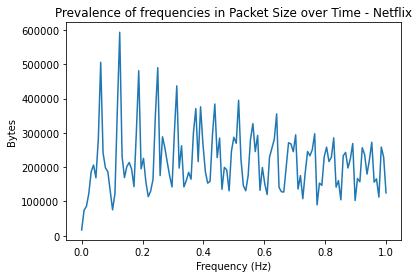

In [13]:
n1_rs = n1_unpacked.resample('500ms').sum()
f, Pxx_den = scipy.signal.welch(n1_rs['size'], fs=2)
plt.semilogy(f, np.sqrt(Pxx_den))
plt.title('Prevalence of frequencies in Packet Size over Time - Netflix');
plt.xlabel('Frequency (Hz)')
plt.ylabel('Bytes')
plt.yscale('linear')


peaks, _ = scipy.signal.find_peaks(np.sqrt(Pxx_den))

prominences = peak_prominences(np.sqrt(Pxx_den), peaks)[0]
netflix_max_prom = prominences.max()

# peaks, _ = scipy.signal.find_peaks(np.sqrt(Pxx_den), prominence = netflix_max_prom)
# plt.plot(np.sqrt(Pxx_den))
#plt.plot(peaks, np.sqrt(Pxx_den)[peaks], "x");
# plt.title('Netflix - Packet Size');

print("Netflix maximum prominence: ", netflix_max_prom)

Youtube maximum prominence:  664966.8085190732


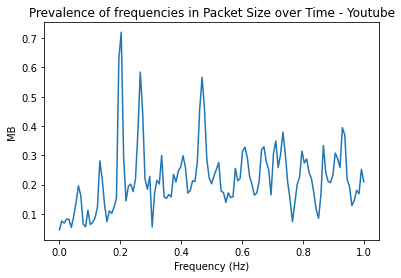

In [17]:
y1_rs = y1_unpacked.resample('500ms').sum()
f, Pxx_den = scipy.signal.welch(y1_rs['size'], fs=2)
plt.semilogy(f, np.sqrt(Pxx_den)/1000000)
plt.title('Prevalence of frequencies in Packet Size over Time - Youtube');
plt.xlabel('Frequency (Hz)')
plt.ylabel('MB')
plt.yscale('linear')

peaks, _ = scipy.signal.find_peaks(np.sqrt(Pxx_den))

prominences = peak_prominences(np.sqrt(Pxx_den), peaks)[0]
youtube_max_prom = prominences.max()
print("Youtube maximum prominence: ", youtube_max_prom)

Amazon Prime maximum prominence:  774583.7861012355


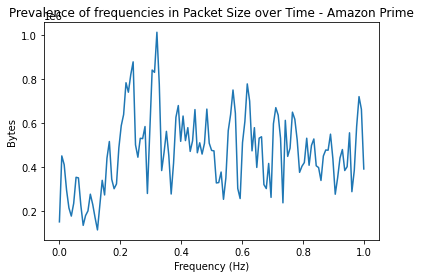

In [89]:
p1_rs = p1_unpacked.resample('500ms').sum()
f, Pxx_den = scipy.signal.welch(p1_rs['size'], fs=2)
plt.semilogy(f, np.sqrt(Pxx_den))
plt.title('Prevalence of frequencies in Packet Size over Time - Amazon Prime');
plt.xlabel('Frequency (Hz)')
plt.ylabel('Bytes')
plt.yscale('linear')

peaks, _ = scipy.signal.find_peaks(np.sqrt(Pxx_den))

prominences = peak_prominences(np.sqrt(Pxx_den), peaks)[0]
prime_max_prom = prominences.max()
print("Amazon Prime maximum prominence: ", prime_max_prom)